In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets sentencepiece

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/home/ubuntu/.local/lib

In [2]:
!pip install -U pip


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 119.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [3]:
!pip install -q pytorch-lightning wandb

### Load dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
})

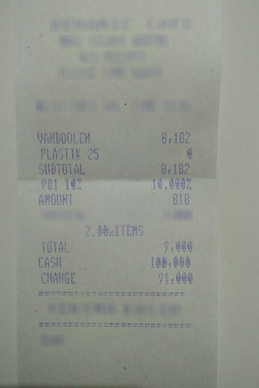

In [6]:
example = dataset['train'][30]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [7]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"menu": [{"nm": "VANDOOLEN", "price": "8,182"}, {"nm": "PLASTIK 25", "price": "0"}], "sub_total": {"subtotal_price": "8,182", "tax_price": "818"}, "total": {"total_price": "9,000", "cashprice": "100,000", "changeprice": "91,000", "menuqty_cnt": "2.00xITEMS"}}, "meta": {"version": "2.0.0", "split": "train", "image_id": 30, "image_size": {"width": 864, "height": 1296}}, "valid_line": [{"words": [{"quad": {"x2": 304, "y3": 482, "x3": 304, "y4": 482, "x1": 122, "y1": 440, "x4": 122, "y2": 440}, "is_key": 0, "row_id": 2219081, "text": "VANDOOLEN"}], "category": "menu.nm", "group_id": 3, "sub_group_id": 0}, {"words": [{"quad": {"x2": 639, "y3": 482, "x3": 639, "y4": 482, "x1": 535, "y1": 438, "x4": 535, "y2": 438}, "is_key": 0, "row_id": 2219081, "text": "8,182"}], "category": "menu.price", "group_id": 3, "sub_group_id": 0}, {"words": [{"quad": {"x2": 274, "y3": 537, "x3": 273, "y4": 534, "x1": 132, "y1": 491, "x4": 131, "y2": 494}, "is_key": 0, "row_id": 2219082, "text": "PLAS

In [8]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'menu': [{'nm': 'VANDOOLEN', 'price': '8,182'},
  {'nm': 'PLASTIK 25', 'price': '0'}],
 'sub_total': {'subtotal_price': '8,182', 'tax_price': '818'},
 'total': {'total_price': '9,000',
  'cashprice': '100,000',
  'changeprice': '91,000',
  'menuqty_cnt': '2.00xITEMS'}}

### Load Model

In [9]:
!pip install protobuf==3.19.4
from transformers import VisionEncoderDecoderConfig

max_length = 768
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 95.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.9
    Uninstalling protobuf-4.21.9:
      Successfully uninstalled protobuf-4.21.9


Downloading:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

In [10]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/lib/python3/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values` and `labels`. Both are PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), and the `labels` are the `input_ids` of the target sequence (which is a flattened version of the JSON), with padding tokens replaced by -100 (to make sure these are ignored by the loss function). 

Note that we're also adding tokens to the vocabulary of the decoder (and corresponding tokenizer) for all keys of the dictionaries in our dataset, like "<s_menu>". This makes sure the model learns an embedding vector for them. Without doing this, some keys might get split up into multiple subword tokens, in which case the model just learns an embedding for the subword tokens, rather than a direct embedding for these keys.

In [11]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [12]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

train_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="validation", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [13]:
len(added_tokens)

56

In [14]:
print(added_tokens)

['<s_menu>', '</s_menu>', '<s_nm>', '</s_nm>', '<s_cnt>', '</s_cnt>', '<s_price>', '</s_price>', '<s_sub_total>', '</s_sub_total>', '<s_subtotal_price>', '</s_subtotal_price>', '<s_service_price>', '</s_service_price>', '<s_tax_price>', '</s_tax_price>', '<s_etc>', '</s_etc>', '<s_total>', '</s_total>', '<s_total_price>', '</s_total_price>', '<s_sub>', '</s_sub>', '<s_cashprice>', '</s_cashprice>', '<s_changeprice>', '</s_changeprice>', '<s_menutype_cnt>', '</s_menutype_cnt>', '<s_menuqty_cnt>', '</s_menuqty_cnt>', '<s_discount_price>', '</s_discount_price>', '<s_unitprice>', '</s_unitprice>', '<s_total_etc>', '</s_total_etc>', '<s_creditcardprice>', '</s_creditcardprice>', '<s_num>', '</s_num>', '<s_discountprice>', '</s_discountprice>', '<s_emoneyprice>', '</s_emoneyprice>', '<s_void_menu>', '</s_void_menu>', '<s_othersvc_price>', '</s_othersvc_price>', '<s_vatyn>', '</s_vatyn>', '<s_itemsubtotal>', '</s_itemsubtotal>', '<s_cord-v2>', '<s_cord-v2>']


In [15]:
len(processor.tokenizer)

57580

In [16]:
processor.tokenizer.vocab_size

57522

In [17]:
processor.decode([57560])

'</s_unitprice>'

In [18]:
pixel_values, labels, target_sequence = train_dataset[0]

In [19]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [20]:
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
Nasi
Camp
ur
Bali
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
7
5,000
</s_price>
<sep/>
<s_nm>
B
b
k
Ben
gil
Nasi
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
12


In [21]:
print(target_sequence)

<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,000.</s_price><sep/><s_nm>Nasi Goren

In [22]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [23]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [24]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [25]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [26]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
Com
bo
1.
</s_nm>
<s_cnt>
2
</s_cnt>
<s_price>

60,000
</s_price>
</s_menu>
<s_total>
<s_total_price>
60
.000
</s_total_price>
<s_cashprice>
60
.000
</s_cashprice>
<s_changeprice>
0
</s_changeprice>
</s_total>
</s>
-100
-100


In [27]:
print(len(train_dataset))
print(len(val_dataset))

800
100


In [28]:
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [29]:
print(target_sequences[0])

<s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total></s>


## Define LightningModule

Next, we define a LightningModule, which is an nn.Module with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [31]:
from pathlib import Path
import re
!pip install nltk
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        cnt = [0] * num_of_loaders
        total_metric = [0] * num_of_loaders
        val_metric = [0] * num_of_loaders
        for i, results in enumerate(validation_step_outputs):
            for scores in results:
                cnt[i] += len(scores)
                total_metric[i] += np.sum(scores)
            val_metric[i] = total_metric[i] / cnt[i]
            val_metric_name = f"val_metric_{i}th_dataset"
            self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # TODO add scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 118.7 MB/s eta 0:00:00


## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [32]:
config = {"max_epochs":20,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [39]:
trainer.create_model_card()

AttributeError: 'Trainer' object has no attribute 'create_model_card'

In [33]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback

wandb_logger = WandbLogger(project="Donut", name="OCR-Donut-CORD_1")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("jinhybr/OCR-Donut-CORD",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("jinhybr/OCR-Donut-CORD",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("jinhybr/OCR-Donut-CORD",
                                    commit_message=f"Training done")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback()],
)

trainer.fit(model_module)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
403.817   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price></s_menu><s_sub_total><s_subtotal_price>16,000</s_total_price><s_cashprice>45,500</s_cashprice><s_changeprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.207492795389049
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23,000</s_price></s_menu><s_sub_total><s_subtotal_price>23,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23,000</s_price></s_menu><s_total><s_total_price>23,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_unitprice>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</s_nm

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><s_sub><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.011494252873563218
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><s_sub><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.011494252873563218
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><s_sub><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.011494252873563218
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

Validation: 0it [00:00, ?it/s]

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu K

`Trainer.fit` stopped: `max_epochs=20` reached.


Pushing model to the hub after training


In [34]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("jinhybr/OCR-Donut-CORD")
model = VisionEncoderDecoderModel.from_pretrained("jinhybr/OCR-Donut-CORD")

Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

In [35]:
!pip install -q donut-python

In [36]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/100 [00:00<?, ?it/s]

{'accuracies': [1.0, 1.0, 0.696629213483146, 0.8705882352941177, 0.9571428571428572, 0.9, 1.0, 1.0, 1.0, 0.9375, 1.0, 0.9936305732484076, 1.0, 1.0, 0.912621359223301, 0.9565217391304348, 0.9777777777777777, 0.9692307692307692, 0.9886363636363636, 1.0, 1.0, 0.8603351955307262, 0.84, 0.9818181818181818, 1.0, 0.8296943231441047, 0.9876543209876543, 0.9838709677419355, 1.0, 0.7936507936507937, 0.975, 1.0, 1.0, 0.9080459770114943, 0.9675324675324676, 1.0, 1.0, 0.11904761904761907, 0.9555555555555556, 0.9517241379310345, 0.6496350364963503, 0.7514970059880239, 1.0, 0.8734177215189873, 0.967741935483871, 1.0, 0.9622641509433962, 1.0, 0.9801980198019802, 1.0, 1.0, 1.0, 0.9770114942528736, 1.0, 0.9789473684210527, 0.7333333333333334, 0.8867924528301887, 0.9916666666666667, 0.9545454545454546, 0.9444444444444444, 0.8727272727272728, 0.9181818181818182, 0.9801980198019802, 0.9696969696969697, 1.0, 1.0, 1.0, 1.0, 0.9824561403508771, 0.9174311926605505, 1.0, 0.7792207792207793, 1.0, 1.0, 1.0, 1.0, 

In [37]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9258010495396338
